### INFO284 Machine Learning Exam, spring 2024 
Przybys & Peter


### Table of contents
1. [Introduction](#introduction)
2. [Project Setup](#project-setup)
2. [Exploring Data](#exploringData)
3. [Data Preprocessing](#data-preprocessing)
4. [Feature Engineering](#feature-engineering)
5. [Modeling](#modeling)
6. [Evaluation](#evaluation)
7. [Conclusion](#conclusion)
8. [References](#references)


### Introduction (136)

This report is about machine learning on fisheries data from Norwegian Directorate of Fisheries. The dataset is from 2018 and several of the original columns have already been removed by our lecturer to create a better reference point. The main objective with our models has been to predict the “Rundvekt” continuous values on species “Torsk”, “Sei, and “Hyse”. This is categorized as a quantitative regression problem and our group has been working according to relevant principles within such a problem space. The report will include reasoning for choices made within data exploration, preprocessing, feature engineering, and the use of the specific machine learning models implemented. The project will implement three supervised machine learning models, including one deep learning model. Additionally, we will develop an unsupervised clustering model, for which a distinct data preprocessing approach is permitted.

### Project Setup <a name="project-setup"></a>

##### Importing and versioncontrol for our choosen libraries

In [196]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))
import seaborn as sns
print("seaborn version: {}".format(sns.__version__))

Python version: 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
pandas version: 2.2.2
matplotlib version: 3.8.4
NumPy version: 1.26.4
SciPy version: 1.13.0
IPython version: 8.23.0
scikit-learn version: 1.4.2
seaborn version: 0.13.2
xgboost version: 2.0.3


#### Importing the dataset

In [197]:
filePath = 'elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv'
# Keep in mind that the file is encoded in UTF-8 so it will only work if you have the correct version of pandas.
df = pd.read_csv(filePath, encoding="UTF-8" , delimiter=";")
print(f"Before pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")

Before pre-processing the dataset has 45 columns and 305434 rows


In [198]:
def status_dataframe(dataframe):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    print(f"Datasettet har nå {dataframe.shape[1]} kolonner og {dataframe.shape[0]} rader")
    display(dataframe.head(5))
    dataframe.info()

status_dataframe(df)

Datasettet har nå 45 kolonner og 305434 rader


,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO (kode),Redskap FAO,Redskap FDIR (kode),Redskap FDIR,Hovedart FAO (kode),Hovedart FAO,Hovedart - FDIR (kode),Art FAO (kode),Art FAO,Art - FDIR (kode),Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,NaN,NaN,-2740,01.01.2018,01.01.2018,00:00,1440,2018,"-60,4","-46,15",NaN,NaN,NaN,-805,5649.0,OTM,"Flytetrål, otter",53.0,Flytetrål,KRI,Antarktisk krill,2513.0,KRI,Antarktisk krill,2513.0,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,HAD,Hyse,1027.0,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,COD,Torsk,1022.0,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,GHL,Blåkveite,2313.0,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,POK,Sei,1032.0,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305434 entries, 0 to 305433
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                305434 non-null  int64  
 1   Meldingstidspunkt         305434 non-null  object 
 2   Meldingsdato              305434 non-null  object 
 3   Meldingsklokkeslett       305434 non-null  object 
 4   Starttidspunkt            305434 non-null  object 
 5   Startdato                 305434 non-null  object 
 6   Startklokkeslett          305434 non-null  object 
 7   Startposisjon bredde      305434 non-null  object 
 8   Startposisjon lengde      305434 non-null  object 
 9   Hovedområde start (kode)  303433 non-null  float64
 10  Hovedområde start         301310 non-null  object 
 11  Lokasjon start (kode)     303433 non-null  float64
 12  Havdybde start            305434 non-null  int64  
 13  Stopptidspunkt            305434 non-null  o

### <a id='#exploringData'></a>Exploring Data

Regarding our problem space we already inherit some knowledge about what datatype we want to work with. So intuitively we know that numerical values will be more relevant than categorical values. It is important not to let this control the data exploration too much, and to take important choices which could be wrong. The data exploration will be about investigating and building the foundation for the reasoning regarding the preprocessing and cleaning of data. At first glance there are 45 columns and 305433 rows. Initially more data is very useful for our deep learning model, but after analyzing various columns there is a large amount of redundancy, 370703 total missing values consisting of, wrong datatypes and plenty of categorical data which may not be relevant for us.

In [199]:
df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO (kode),Redskap FAO,Redskap FDIR (kode),Redskap FDIR,Hovedart FAO (kode),Hovedart FAO,Hovedart - FDIR (kode),Art FAO (kode),Art FAO,Art - FDIR (kode),Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,NaN,NaN,-2740,01.01.2018,01.01.2018,00:00,1440,2018,"-60,4","-46,15",NaN,NaN,NaN,-805,5649.0,OTM,"Flytetrål, otter",53.0,Flytetrål,KRI,Antarktisk krill,2513.0,KRI,Antarktisk krill,2513.0,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,HAD,Hyse,1027.0,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,COD,Torsk,1022.0,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,GHL,Blåkveite,2313.0,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,POK,Sei,1032.0,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305434 entries, 0 to 305433
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                305434 non-null  int64  
 1   Meldingstidspunkt         305434 non-null  object 
 2   Meldingsdato              305434 non-null  object 
 3   Meldingsklokkeslett       305434 non-null  object 
 4   Starttidspunkt            305434 non-null  object 
 5   Startdato                 305434 non-null  object 
 6   Startklokkeslett          305434 non-null  object 
 7   Startposisjon bredde      305434 non-null  object 
 8   Startposisjon lengde      305434 non-null  object 
 9   Hovedområde start (kode)  303433 non-null  float64
 10  Hovedområde start         301310 non-null  object 
 11  Lokasjon start (kode)     303433 non-null  float64
 12  Havdybde start            305434 non-null  int64  
 13  Stopptidspunkt            305434 non-null  o

In [201]:
df.isnull().sum().sum()

370703

In [202]:
df.isnull().sum()

Melding ID                       0
Meldingstidspunkt                0
Meldingsdato                     0
Meldingsklokkeslett              0
Starttidspunkt                   0
Startdato                        0
Startklokkeslett                 0
Startposisjon bredde             0
Startposisjon lengde             0
Hovedområde start (kode)      2001
Hovedområde start             4124
Lokasjon start (kode)         2001
Havdybde start                   0
Stopptidspunkt                   0
Stoppdato                        0
Stoppklokkeslett                 0
Varighet                         0
Fangstår                         0
Stopposisjon bredde              0
Stopposisjon lengde              0
Hovedområde stopp (kode)      1962
Hovedområde stopp             4124
Lokasjon stopp (kode)         1962
Havdybde stopp                   0
Trekkavstand                    24
Redskap FAO (kode)               0
Redskap FAO                    188
Redskap FDIR (kode)            188
Redskap FDIR        

In [203]:
#checking for redundant columns
df.nunique()

Melding ID                  49437
Meldingstidspunkt           44411
Meldingsdato                  366
Meldingsklokkeslett          1440
Starttidspunkt              89322
Startdato                     375
Startklokkeslett             1440
Startposisjon bredde        18063
Startposisjon lengde        35508
Hovedområde start (kode)       56
Hovedområde start              55
Lokasjon start (kode)          83
Havdybde start               2375
Stopptidspunkt              89701
Stoppdato                     366
Stoppklokkeslett             1440
Varighet                     4593
Fangstår                        2
Stopposisjon bredde         18193
Stopposisjon lengde         35871
Hovedområde stopp (kode)       57
Hovedområde stopp              55
Lokasjon stopp (kode)          82
Havdybde stopp               2378
Trekkavstand                31409
Redskap FAO (kode)             31
Redskap FAO                    30
Redskap FDIR (kode)            17
Redskap FDIR                   17
Hovedart FAO (

In [204]:
print(df['Art FAO'].value_counts())
print(df['Art - FDIR'].value_counts())
print(df['Art - gruppe'].value_counts())
print(df['Hovedart FAO'].value_counts())

Art FAO
Torsk                  56574
Sei                    42557
Hyse                   39120
Lange                  17338
Uer (vanlig)           14153
                       ...  
Sagtang                    1
Annen makrell              1
Blåhval                    1
Annen laksefisk            1
Bukstripet pelamide        1
Name: count, Length: 122, dtype: int64
Art - FDIR
Torsk                  56574
Sei                    42557
Hyse                   39120
Lange                  17338
Uer (vanlig)           14153
                       ...  
Sagtang                    1
Annen makrell              1
Blåhval                    1
Annen laksefisk            1
Bukstripet pelamide        1
Name: count, Length: 122, dtype: int64
Art - gruppe
Torsk                                       56574
Annen torskefisk                            45286
Sei                                         42557
Hyse                                        39120
Annen flatfisk, bunnfisk og dypvannsfisk    25267
Ue

dropp kommentarer. except for tekniske ting
vise dataen underveis
dropna, påstander om hvorfor vi dropper de, bevis 
vise distribusjon av outliers
fillNA, groupBy, meldingsid, startstidspunkt
robustScaler, hvorfor vi bruker det, outliers
scalingData for modellene, forklar
gradientBoosting, scaling data hvorfor? Bedre optimum, forklare MultioutputRegressor
MLPR, not converging, learning rate importances
viktig train validation og test splits,
forklare typene features, 
skaleringen fit skal bare være på treningsdataen, skalering skal kun være minste og største verdiene i treningsdataen. 
scaler.fit()transform på treningsdataen
validationset ikke hellig, testdata = helt skjult frem til eksamen.
scaler.fit på testset

In [205]:
# Using the same seed for testing purposes makes the results more comparable
seed = 32

In [206]:
df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO (kode),Redskap FAO,Redskap FDIR (kode),Redskap FDIR,Hovedart FAO (kode),Hovedart FAO,Hovedart - FDIR (kode),Art FAO (kode),Art FAO,Art - FDIR (kode),Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,NaN,NaN,-2740,01.01.2018,01.01.2018,00:00,1440,2018,"-60,4","-46,15",NaN,NaN,NaN,-805,5649.0,OTM,"Flytetrål, otter",53.0,Flytetrål,KRI,Antarktisk krill,2513.0,KRI,Antarktisk krill,2513.0,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,HAD,Hyse,1027.0,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,COD,Torsk,1022.0,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,GHL,Blåkveite,2313.0,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,POK,Sei,1032.0,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


In [207]:
# Excluding irrelevant columns

# Fangstår has only 2 unique values
df.drop(columns = ['Fangstår'], inplace= True)

# Lengdegruppe (kode), Lengdegruppe, Bruttotonnasje 1969, Bruttotonnasje annen, Bredde, Fartøylengde all seem to be speaking of the boat doing the catching, with few unique values in each column.
# One of them should be kept as a feature, the rest discarded. We would suggest the most relevant to be Bruttotonasje, which speaks to how much cargo space there is.
# "Bruttotonnasje 1969" and "Bruttotonnasje annen" seem to have nan where the other one has a value, so first we will collapse them into one.
df['Bruttotonnasje'] = df['Bruttotonnasje annen'].combine_first(df['Bruttotonnasje 1969'])
df.drop(columns=['Bruttotonnasje annen', "Bruttotonnasje 1969", "Lengdegruppe", 'Bredde', 'Lengdegruppe (kode)'], inplace=True)

# All columns (kode) in them are cateogrical code representations of another column. For human-readability and to avoid mistaking the code for a continuous value we will remove them.
df.drop(columns=["Hovedområde start (kode)", "Lokasjon start (kode)", "Hovedområde stopp (kode)", "Lokasjon stopp (kode)", "Redskap FAO (kode)", "Redskap FDIR (kode)", "Hovedart FAO (kode)", "Hovedart - FDIR (kode)", "Art FAO (kode)", "Art - FDIR (kode)", "Art - gruppe (kode)", ], inplace = True)

# In both the "Redskap" and "Art" columns you have FAO and FDIR abbriviations. FAO = Food and Agriculture Organization of the United Nations and FDIR = Fiskeridirektoratet
# Due to "Hovedart" onyl having FAO uncoded we will stick to FAO. For the same reason we will remove "Art - gruppe"
df.drop(columns=["Art - gruppe", "Art - FDIR", "Redskap FDIR", 'Hovedart FAO'], inplace=True)

# The areas where they start and stop have 6 columns. A pair of coordiantes and name of area x2. Since we prefer the continuous features and coordinates=name of place we are removing the name.
df.drop(columns=["Hovedområde start", "Hovedområde stopp"], inplace=True)

# While time of day and date might be relevant we don't need all of them and we don't need to know when it was reported in. For now we will leave start/end date and time.
df.drop(columns=["Meldingsklokkeslett"], inplace=True)

# After trying to transform the remaining time columns into continuous values we could use they seemed to have no other effect on the result then longer prosessing time.
# df.drop(columns=['Startdato', "Startklokkeslett", "Stoppdato", "Stoppklokkeslett"], inplace=True)

In [208]:
df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Redskap FAO,Art FAO,Rundvekt,Fartøylengde,Bruttotonnasje
0,1497177,01.01.2018,01.01.2018,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",-2740,01.01.2018,01.01.2018,00:00,1440,"-60,4","-46,15",-805,5649.0,"Flytetrål, otter",Antarktisk krill,706714.0,"133,88",9432.0
1,1497178,01.01.2018,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Hyse,9594.0,"56,8",1476.0
2,1497178,01.01.2018,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Torsk,8510.0,"56,8",1476.0
3,1497178,01.01.2018,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Blåkveite,196.0,"56,8",1476.0
4,1497178,01.01.2018,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Sei,134.0,"56,8",1476.0


In [209]:
df.shape

(305434, 22)

In [210]:
status_dataframe(df)

Datasettet har nå 22 kolonner og 305434 rader


,Melding ID,Meldingstidspunkt,Meldingsdato,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Redskap FAO,Art FAO,Rundvekt,Fartøylengde,Bruttotonnasje
0,1497177,01.01.2018,01.01.2018,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",-2740,01.01.2018,01.01.2018,00:00,1440,"-60,4","-46,15",-805,5649.0,"Flytetrål, otter",Antarktisk krill,706714.0,"133,88",9432.0
1,1497178,01.01.2018,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Hyse,9594.0,"56,8",1476.0
2,1497178,01.01.2018,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Torsk,8510.0,"56,8",1476.0
3,1497178,01.01.2018,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Blåkveite,196.0,"56,8",1476.0
4,1497178,01.01.2018,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Sei,134.0,"56,8",1476.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305434 entries, 0 to 305433
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Melding ID            305434 non-null  int64  
 1   Meldingstidspunkt     305434 non-null  object 
 2   Meldingsdato          305434 non-null  object 
 3   Starttidspunkt        305434 non-null  object 
 4   Startdato             305434 non-null  object 
 5   Startklokkeslett      305434 non-null  object 
 6   Startposisjon bredde  305434 non-null  object 
 7   Startposisjon lengde  305434 non-null  object 
 8   Havdybde start        305434 non-null  int64  
 9   Stopptidspunkt        305434 non-null  object 
 10  Stoppdato             305434 non-null  object 
 11  Stoppklokkeslett      305434 non-null  object 
 12  Varighet              305434 non-null  int64  
 13  Stopposisjon bredde   305434 non-null  object 
 14  Stopposisjon lengde   305434 non-null  object 
 15  

count                       305434
mean     0 days 05:45:37.651996830
std      0 days 17:58:05.264515585
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:00:00
max              111 days 00:00:00
Name: time_difference, dtype: object


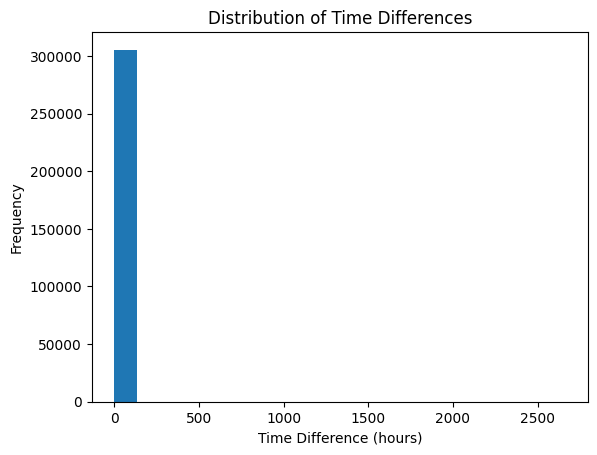

In [211]:
df['date_past'] = pd.to_datetime(df['Stoppdato'], format='%d.%m.%Y')
df['date_future'] = pd.to_datetime(df['Meldingsdato'], format='%d.%m.%Y')

df['time_difference'] = df['date_future'] - df['date_past']

# Analyze the distribution of time differences
time_difference_stats = df['time_difference'].describe()

# Print summary statistics
print(time_difference_stats)

(df['time_difference'] / pd.Timedelta(hours=1)).plot.hist(bins=20)  # Convert to hours for better visualization
plt.xlabel('Time Difference (hours)')
plt.ylabel('Frequency')
plt.title('Distribution of Time Differences')
plt.show()

In [212]:
df['time_difference'].value_counts()

time_difference
0 days      234764
1 days       70216
2 days         210
4 days          59
3 days          54
6 days          39
5 days          24
18 days         23
19 days          8
7 days           8
88 days          7
14 days          4
8 days           4
11 days          2
10 days          2
111 days         2
87 days          2
12 days          2
15 days          1
28 days          1
9 days           1
82 days          1
Name: count, dtype: int64

In [213]:
def circular_encoder(data, max_val):
    sin_encoded = np.sin(2 * np.pi * data / max_val)
    cos_encoded = np.cos(2 * np.pi * data / max_val)
    return sin_encoded, cos_encoded

In [214]:
def circular_encode(data, max_val):
    sin_encoded = np.sin(2 * np.pi * data / max_val)
    cos_encoded = np.cos(2 * np.pi * data / max_val)
    return sin_encoded, cos_encoded
df['Startposisjon bredde'] = df['Startposisjon bredde'].str.replace(',', '.').astype(float)
df['Startposisjon lengde'] = df['Startposisjon lengde'].str.replace(',', '.').astype(float)
df['Stopposisjon bredde'] = df['Stopposisjon bredde'].str.replace(',', '.').astype(float)
df['Stopposisjon lengde'] = df['Stopposisjon lengde'].str.replace(',', '.').astype(float)

df['Startposisjon bredde_sin'], df['Startposisjon bredde_cos'] = circular_encoder(df['Startposisjon bredde'], 180)
df['Startposisjon lengde_sin'], df['Startposisjon lengde_cos'] = circular_encoder(df['Startposisjon lengde'], 360)
df['Stopposisjon bredde_sin'], df['Stopposisjon bredde_cos'] = circular_encoder(df['Stopposisjon bredde'], 180)
df['Stopposisjon lengde_sin'], df['Stopposisjon lengde_cos'] = circular_encoder(df['Stopposisjon lengde'], 360)

df.drop(columns=["Startposisjon bredde", "Startposisjon lengde", 'Stopposisjon bredde', 'Stopposisjon lengde'], inplace=True)
status_dataframe(df)

Datasettet har nå 29 kolonner og 305434 rader


,Melding ID,Meldingstidspunkt,Meldingsdato,Starttidspunkt,Startdato,Startklokkeslett,Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Havdybde stopp,Trekkavstand,Redskap FAO,Art FAO,Rundvekt,Fartøylengde,Bruttotonnasje,date_past,date_future,time_difference,Startposisjon bredde_sin,Startposisjon bredde_cos,Startposisjon lengde_sin,Startposisjon lengde_cos,Stopposisjon bredde_sin,Stopposisjon bredde_cos,Stopposisjon lengde_sin,Stopposisjon lengde_cos
0,1497177,01.01.2018,01.01.2018,31.12.2017,31.12.2017,00:00,-2740,01.01.2018,01.01.2018,00:00,1440,-805,5649.0,"Flytetrål, otter",Antarktisk krill,706714.0,"133,88",9432.0,2018-01-01,2018-01-01,0 days,-0.859852,-0.510543,-0.720950,0.692987,-0.858960,-0.512043,-0.721156,0.692773
1,1497178,01.01.2018,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,-335,31.12.2017 04:16,31.12.2017,04:16,295,-334,3970.0,"Bunntrål, otter",Hyse,9594.0,"56,8",1476.0,2017-12-31,2018-01-01,1 days,0.503472,-0.864011,0.276443,0.961030,0.502598,-0.864521,0.275117,0.961411
2,1497178,01.01.2018,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,-335,31.12.2017 04:16,31.12.2017,04:16,295,-334,3970.0,"Bunntrål, otter",Torsk,8510.0,"56,8",1476.0,2017-12-31,2018-01-01,1 days,0.503472,-0.864011,0.276443,0.961030,0.502598,-0.864521,0.275117,0.961411
3,1497178,01.01.2018,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,-335,31.12.2017 04:16,31.12.2017,04:16,295,-334,3970.0,"Bunntrål, otter",Blåkveite,196.0,"56,8",1476.0,2017-12-31,2018-01-01,1 days,0.503472,-0.864011,0.276443,0.961030,0.502598,-0.864521,0.275117,0.961411
4,1497178,01.01.2018,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,-335,31.12.2017 04:16,31.12.2017,04:16,295,-334,3970.0,"Bunntrål, otter",Sei,134.0,"56,8",1476.0,2017-12-31,2018-01-01,1 days,0.503472,-0.864011,0.276443,0.961030,0.502598,-0.864521,0.275117,0.961411


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305434 entries, 0 to 305433
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype          
---  ------                    --------------   -----          
 0   Melding ID                305434 non-null  int64          
 1   Meldingstidspunkt         305434 non-null  object         
 2   Meldingsdato              305434 non-null  object         
 3   Starttidspunkt            305434 non-null  object         
 4   Startdato                 305434 non-null  object         
 5   Startklokkeslett          305434 non-null  object         
 6   Havdybde start            305434 non-null  int64          
 7   Stopptidspunkt            305434 non-null  object         
 8   Stoppdato                 305434 non-null  object         
 9   Stoppklokkeslett          305434 non-null  object         
 10  Varighet                  305434 non-null  int64          
 11  Havdybde stopp            305434 non-null  int64    

In [215]:
df.shape

(305434, 29)

In [216]:
# After having checked to see what % of each column had nan values we decided just to drop them as at worst they were around 1.6 %
df = df.dropna()

In [217]:
df.shape

(297281, 29)

In [218]:
# Focusing down on the species we want to investigate
df = df[df['Art FAO'].isin(['Torsk', 'Sei', 'Hyse'])]

In [219]:
# Removing parts of columns

# From varighet we remove anyting above 400 as according to lecturer that is in the high range of how long you would be fishing in a session.
# So we will consider them outliers or multiple sessions reported as one and exclude them for now.

df = df[df['Varighet'] <= 400]

# Removing outliers from "Trekkavstand" as above 50000 the frequency gets 100 instances per 5000 length.
df = df[df['Trekkavstand'] <= 50000]

In [220]:
df.shape

(108619, 29)

In [221]:
# Manipulating columns

# The coordinates are strings, changing them to int for easier use.
# df['Startposisjon bredde'] = df['Startposisjon bredde'].str.replace(',', '').astype(int)
# df['Startposisjon lengde'] = df['Startposisjon lengde'].str.replace(',', '').astype(int)
# df['Stopposisjon bredde'] = df['Stopposisjon bredde'].str.replace(',', '').astype(int)
# df['Stopposisjon lengde'] = df['Stopposisjon lengde'].str.replace(',', '').astype(int)

df['Trekkavstand'] = df['Trekkavstand'].astype(int)
df['Bruttotonnasje'] = df['Bruttotonnasje'].astype(int)
df['Varighet'] = df['Varighet'].astype(int)
# df['Startmåned'] = df['Startdato'].astype(str).str[3:5]
# df['Starttime'] = df['Startklokkeslett'].astype(str).str[3:5]
# df['Stoppmåned'] = df['Stoppdato'].astype(str).str[3:5]
# df['Stopptime'] = df['Stoppklokkeslett'].astype(str).str[3:5]

# Many of the sea depth notations are positiv, which doesn't make sense.
# But the amount of them in relation to number of entries means it can't be discounted as an error
# In the lecture on fisheries it was mentioned that a lot fo these are inputed manually
# And that most of these non-sensical sea depths are actually correct, just lacking a minus.
# Therefore we are simply flipping all the positive sea depth into negatives.
df['Havdybde start'] = -df['Havdybde start'].abs()
df['Havdybde stopp'] = -df['Havdybde stopp'].abs()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108619 entries, 1 to 305428
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype          
---  ------                    --------------   -----          
 0   Melding ID                108619 non-null  int64          
 1   Meldingstidspunkt         108619 non-null  object         
 2   Meldingsdato              108619 non-null  object         
 3   Starttidspunkt            108619 non-null  object         
 4   Startdato                 108619 non-null  object         
 5   Startklokkeslett          108619 non-null  object         
 6   Havdybde start            108619 non-null  int64          
 7   Stopptidspunkt            108619 non-null  object         
 8   Stoppdato                 108619 non-null  object         
 9   Stoppklokkeslett          108619 non-null  object         
 10  Varighet                  108619 non-null  int32          
 11  Havdybde stopp            108619 non-null  int64         

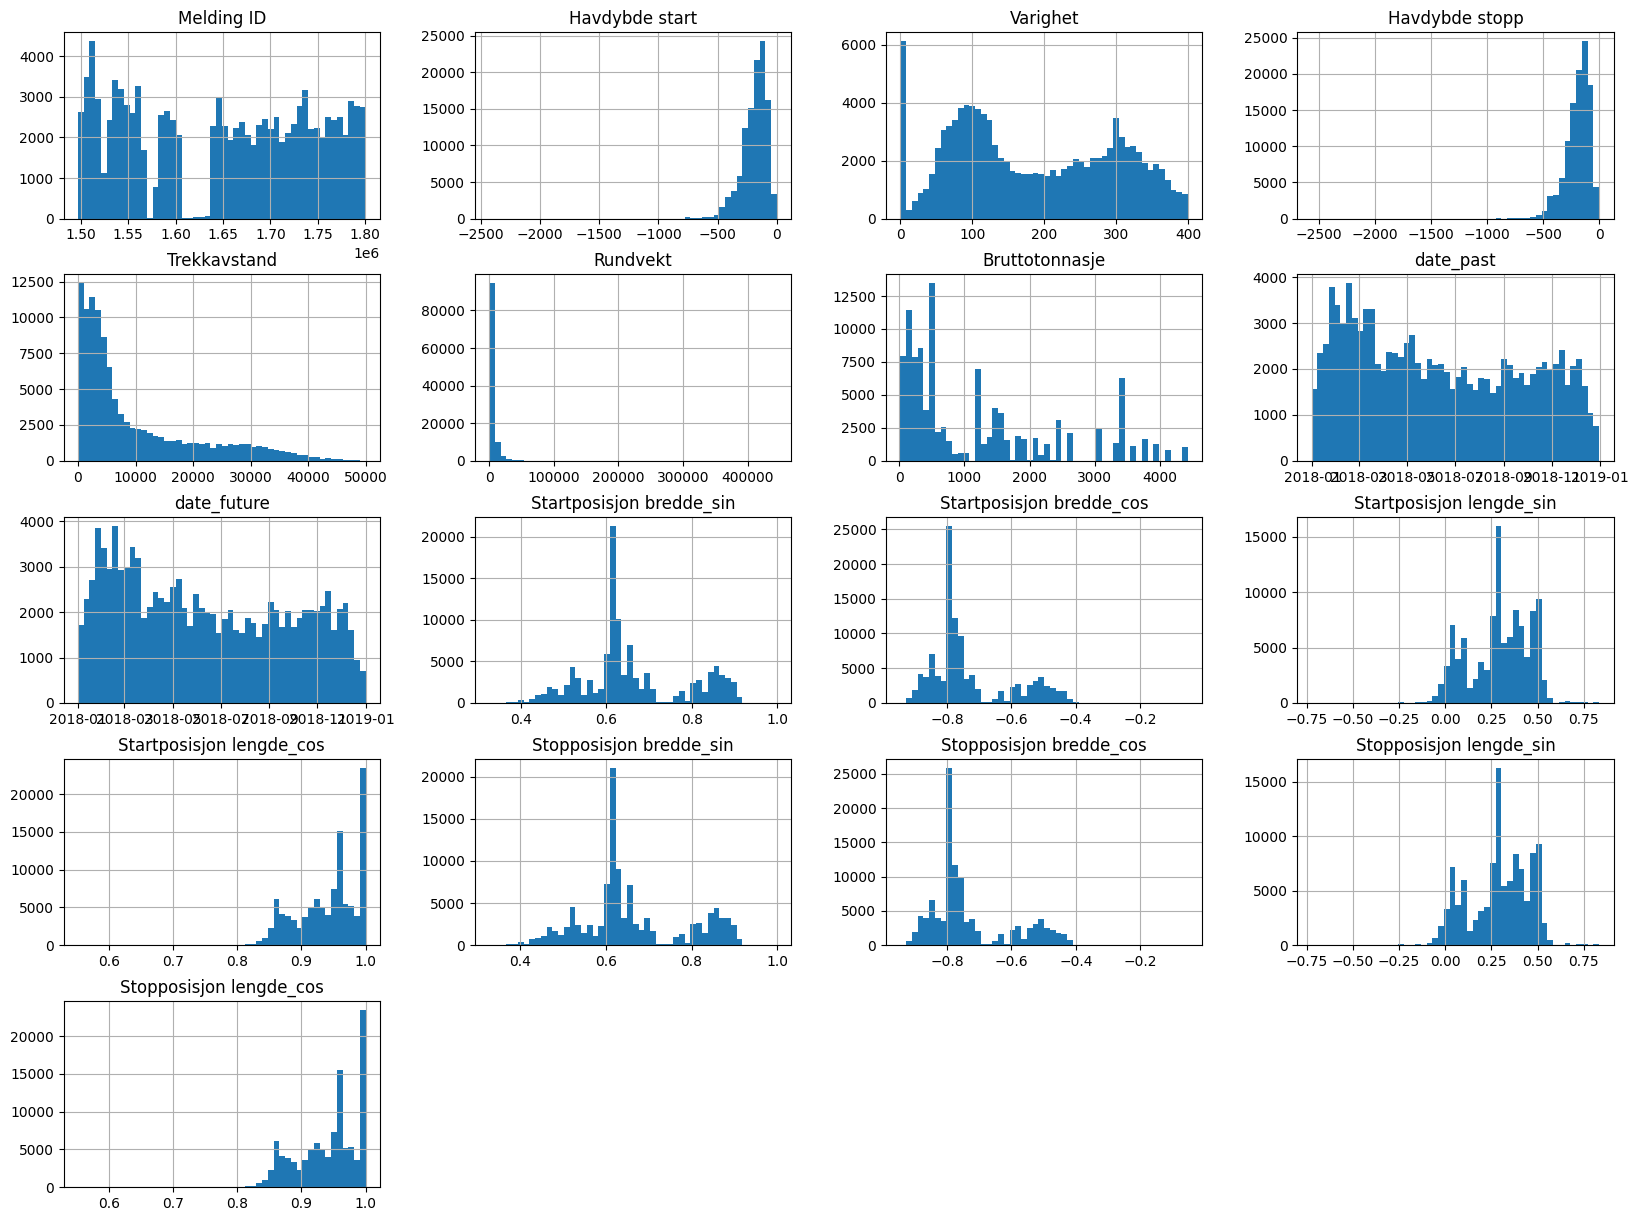

In [222]:
#looking at distribution of all numerical columns
df.hist(bins=50, figsize=(20,15))
plt.show()


Art FAO
Torsk    43757
Sei      32988
Hyse     31874
Name: count, dtype: int64


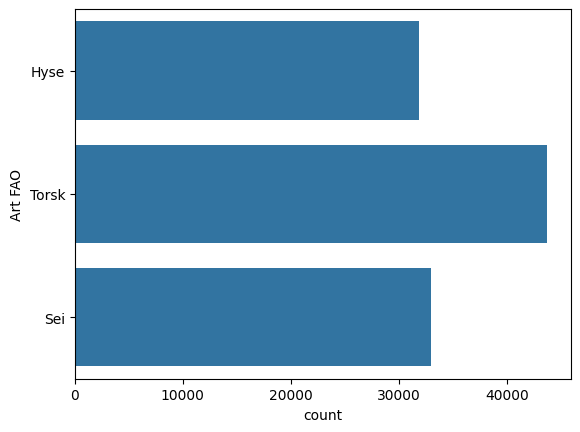

In [223]:
#counting species
print(df['Art FAO'].value_counts())
#plotting species
sns.countplot(df['Art FAO'])
plt.show()

In [224]:
#counting unique again
df.nunique()

Melding ID                  22345
Meldingstidspunkt           21249
Meldingsdato                  366
Starttidspunkt              48314
Startdato                     367
Startklokkeslett             1440
Havdybde start                710
Stopptidspunkt              48259
Stoppdato                     366
Stoppklokkeslett             1440
Varighet                      401
Havdybde stopp                757
Trekkavstand                21201
Redskap FAO                    25
Art FAO                         3
Rundvekt                    14291
Fartøylengde                  288
Bruttotonnasje                297
date_past                     366
date_future                   366
time_difference                 8
Startposisjon bredde_sin    13395
Startposisjon bredde_cos    13395
Startposisjon lengde_sin    21756
Startposisjon lengde_cos    21003
Stopposisjon bredde_sin     13479
Stopposisjon bredde_cos     13479
Stopposisjon lengde_sin     22105
Stopposisjon lengde_cos     21333
dtype: int64

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108619 entries, 1 to 305428
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype          
---  ------                    --------------   -----          
 0   Melding ID                108619 non-null  int64          
 1   Meldingstidspunkt         108619 non-null  object         
 2   Meldingsdato              108619 non-null  object         
 3   Starttidspunkt            108619 non-null  object         
 4   Startdato                 108619 non-null  object         
 5   Startklokkeslett          108619 non-null  object         
 6   Havdybde start            108619 non-null  int64          
 7   Stopptidspunkt            108619 non-null  object         
 8   Stoppdato                 108619 non-null  object         
 9   Stoppklokkeslett          108619 non-null  object         
 10  Varighet                  108619 non-null  int32          
 11  Havdybde stopp            108619 non-null  int64         

The next step was to pivot the data in it's own dataframe so we could get species Hyse, Sei, and Torsk on the same row for each fishing line of the same boats. The reason why pivoting the table instead of using groupby

In [226]:
#counting instances of Torsk
df['Art FAO'].value_counts()

Art FAO
Torsk    43757
Sei      32988
Hyse     31874
Name: count, dtype: int64

In [227]:
print(f"Before pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")

Before pre-processing the dataset has 29 columns and 108619 rows


In [228]:
# Pivoting table so rows that are information about the same session are put together
print(f"Before pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")
df = df.pivot_table(index=['Melding ID','Starttidspunkt','Startposisjon bredde_sin','Startposisjon lengde_sin','Startposisjon bredde_cos', 'Startposisjon lengde_cos', 'Stopposisjon bredde_sin', 'Stopposisjon bredde_cos', 'Stopposisjon lengde_sin', 'Stopposisjon lengde_cos', 'Havdybde start', 'Varighet', 'Havdybde stopp', 'Trekkavstand',
'Redskap FAO','Bruttotonnasje'],
columns='Art FAO', values='Rundvekt').reset_index()
print(f"After pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")


Before pre-processing the dataset has 29 columns and 108619 rows
After pre-processing the dataset has 19 columns and 51080 rows


In [229]:
df.head()

Art FAO,Melding ID,Starttidspunkt,Startposisjon bredde_sin,Startposisjon lengde_sin,Startposisjon bredde_cos,Startposisjon lengde_cos,Stopposisjon bredde_sin,Stopposisjon bredde_cos,Stopposisjon lengde_sin,Stopposisjon lengde_cos,Havdybde start,Varighet,Havdybde stopp,Trekkavstand,Redskap FAO,Bruttotonnasje,Hyse,Sei,Torsk
0,1497178,30.12.2017 23:21,0.503472,0.276443,-0.864011,0.961030,0.502598,-0.864521,0.275117,0.961411,-335,295,-334,3970,"Bunntrål, otter",1476,9594.0,134.0,8510.0
1,1497178,31.12.2017 05:48,0.502718,0.273422,-0.864450,0.961894,0.502990,-0.864292,0.279796,0.960060,-403,267,-277,11096,"Bunntrål, otter",1476,9118.0,67.0,6651.0
2,1497178,31.12.2017 11:34,0.503533,0.276577,-0.863976,0.960992,0.502296,-0.864696,0.271306,0.962493,-346,315,-496,10215,"Bunntrål, otter",1476,12432.0,68.0,5097.0
3,1497178,31.12.2017 17:44,0.502084,0.272028,-0.864819,0.962289,0.502235,-0.864731,0.273859,0.961770,-443,243,-358,3214,"Bunntrål, otter",1476,6758.0,NaN,7022.0
4,1497229,01.01.2018 10:01,0.698965,0.224475,-0.715156,0.974480,0.698990,-0.715132,0.223965,0.974597,-71,63,-56,1269,Snurrevad,51,4.0,NaN,NaN


In [230]:
df.isna().sum()

Art FAO
Melding ID                      0
Starttidspunkt                  0
Startposisjon bredde_sin        0
Startposisjon lengde_sin        0
Startposisjon bredde_cos        0
Startposisjon lengde_cos        0
Stopposisjon bredde_sin         0
Stopposisjon bredde_cos         0
Stopposisjon lengde_sin         0
Stopposisjon lengde_cos         0
Havdybde start                  0
Varighet                        0
Havdybde stopp                  0
Trekkavstand                    0
Redskap FAO                     0
Bruttotonnasje                  0
Hyse                        19206
Sei                         18092
Torsk                        7326
dtype: int64

In [231]:
df.isnull().sum().sum()

44624

In [232]:
df.head()

Art FAO,Melding ID,Starttidspunkt,Startposisjon bredde_sin,Startposisjon lengde_sin,Startposisjon bredde_cos,Startposisjon lengde_cos,Stopposisjon bredde_sin,Stopposisjon bredde_cos,Stopposisjon lengde_sin,Stopposisjon lengde_cos,Havdybde start,Varighet,Havdybde stopp,Trekkavstand,Redskap FAO,Bruttotonnasje,Hyse,Sei,Torsk
0,1497178,30.12.2017 23:21,0.503472,0.276443,-0.864011,0.961030,0.502598,-0.864521,0.275117,0.961411,-335,295,-334,3970,"Bunntrål, otter",1476,9594.0,134.0,8510.0
1,1497178,31.12.2017 05:48,0.502718,0.273422,-0.864450,0.961894,0.502990,-0.864292,0.279796,0.960060,-403,267,-277,11096,"Bunntrål, otter",1476,9118.0,67.0,6651.0
2,1497178,31.12.2017 11:34,0.503533,0.276577,-0.863976,0.960992,0.502296,-0.864696,0.271306,0.962493,-346,315,-496,10215,"Bunntrål, otter",1476,12432.0,68.0,5097.0
3,1497178,31.12.2017 17:44,0.502084,0.272028,-0.864819,0.962289,0.502235,-0.864731,0.273859,0.961770,-443,243,-358,3214,"Bunntrål, otter",1476,6758.0,NaN,7022.0
4,1497229,01.01.2018 10:01,0.698965,0.224475,-0.715156,0.974480,0.698990,-0.715132,0.223965,0.974597,-71,63,-56,1269,Snurrevad,51,4.0,NaN,NaN


In [233]:
df.isnull().sum()

Art FAO
Melding ID                      0
Starttidspunkt                  0
Startposisjon bredde_sin        0
Startposisjon lengde_sin        0
Startposisjon bredde_cos        0
Startposisjon lengde_cos        0
Stopposisjon bredde_sin         0
Stopposisjon bredde_cos         0
Stopposisjon lengde_sin         0
Stopposisjon lengde_cos         0
Havdybde start                  0
Varighet                        0
Havdybde stopp                  0
Trekkavstand                    0
Redskap FAO                     0
Bruttotonnasje                  0
Hyse                        19206
Sei                         18092
Torsk                        7326
dtype: int64

In [234]:
#using knnimputer to fill nan values in Hyse, Sei and Torsk columns
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# df[['Hyse', 'Sei', 'Torsk']] = imputer.fit_transform(df[['Hyse', 'Sei', 'Torsk']])
# df.isnull().sum().sum()

#filling nan values with the median of Hyse, Sei, Torsk
# df['Hyse'] = df['Hyse'].fillna(df['Hyse'].median())
# df['Sei'] = df['Sei'].fillna(df['Sei'].median())
# df['Torsk'] = df['Torsk'].fillna(df['Torsk'].median())
# df.isnull().sum().sum()

#using MissForest to fill nan values
# from missforest.missforest import MissForest
# imputer = MissForest()
# df[['Hyse', 'Sei', 'Torsk']] = imputer.fit_transform(df[['Hyse', 'Sei', 'Torsk']])
# df.isnull().sum().sum()


#dropping nan values
# df.dropna(inplace=True)
#filling nan with 0


In [235]:
df.fillna(0, inplace=True)
df.isnull().sum().sum()

0

In [236]:
df.shape

(51080, 19)

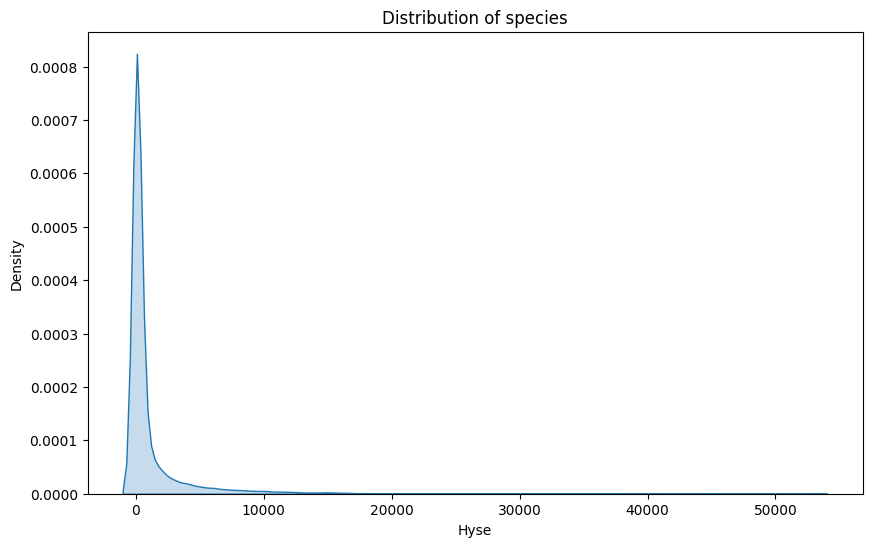

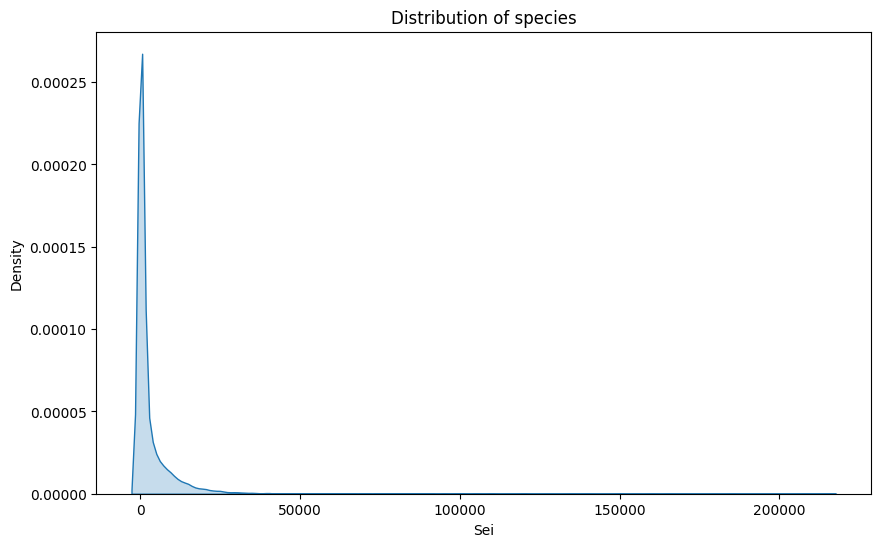

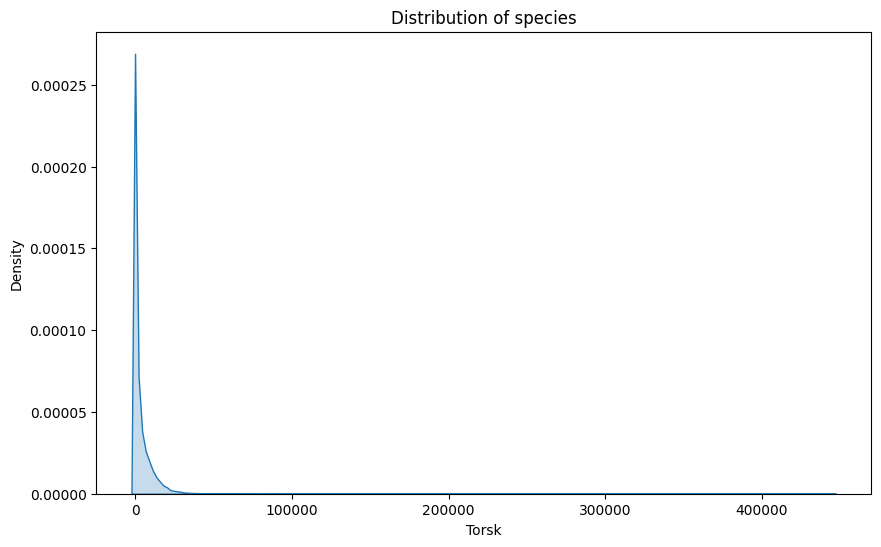

In [237]:
#plotting the distribution of the species
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Hyse'], label='Hyse', fill=True)
plt.title('Distribution of species')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['Sei'], label='Sei', fill=True)
plt.title('Distribution of species')

plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['Torsk'], label='Torsk', fill=True)
plt.title('Distribution of species')
plt.show()

In [238]:
#counting instances of species over 15000 value
# print(df[df['Hyse'] > 15000].shape)
# print(df[df['Sei'] > 15000].shape)
# print(df[df['Torsk'] > 15000].shape)



In [239]:
print(df[df['Hyse'] > 10000].shape)
print(df[df['Sei'] > 10000].shape)
print(df[df['Torsk'] > 10000].shape)

(1364, 19)
(4450, 19)
(5934, 19)


In [240]:
#cutting off every value above 10000 in Hyse, Sei and Torsk
df = df[df['Hyse'] <= 14596]
df = df[df['Sei']  <= 14596]
df = df[df['Torsk']<= 14596]

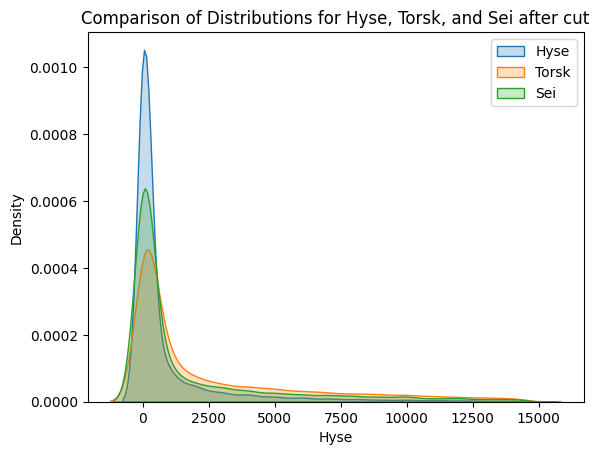

In [241]:
import seaborn as sns
#plotting the distribution of the species
sns.kdeplot(df['Hyse'], label='Hyse', fill=True)

# Plot KDE for 'Torsk'
sns.kdeplot(df['Torsk'], label='Torsk', fill=True)

# Plot KDE for 'Sei'
sns.kdeplot(df['Sei'], label='Sei', fill=True)

# Adding title
plt.title('Comparison of Distributions for Hyse, Torsk, and Sei after cut')

# Show the plot with all KDEs on the same graph
plt.legend()
plt.show()

In [242]:
print(df[df['Hyse'] > 14596].shape)
print(df[df['Sei'] > 14596].shape)
print(df[df['Torsk'] > 14596].shape)

(0, 19)
(0, 19)
(0, 19)


In [243]:
#unqiue values in columns
df.nunique()

Art FAO
Melding ID                  20864
Starttidspunkt              42666
Startposisjon bredde_sin    12694
Startposisjon lengde_sin    20280
Startposisjon bredde_cos    12694
Startposisjon lengde_cos    19586
Stopposisjon bredde_sin     12758
Stopposisjon bredde_cos     12758
Stopposisjon lengde_sin     20546
Stopposisjon lengde_cos     19852
Havdybde start                706
Varighet                      401
Havdybde stopp                752
Trekkavstand                19814
Redskap FAO                    25
Bruttotonnasje                296
Hyse                         3964
Sei                          6236
Torsk                        7579
dtype: int64

In [244]:

print(f"After pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")
df.head()

After pre-processing the dataset has 19 columns and 44786 rows


Art FAO,Melding ID,Starttidspunkt,Startposisjon bredde_sin,Startposisjon lengde_sin,Startposisjon bredde_cos,Startposisjon lengde_cos,Stopposisjon bredde_sin,Stopposisjon bredde_cos,Stopposisjon lengde_sin,Stopposisjon lengde_cos,Havdybde start,Varighet,Havdybde stopp,Trekkavstand,Redskap FAO,Bruttotonnasje,Hyse,Sei,Torsk
0,1497178,30.12.2017 23:21,0.503472,0.276443,-0.864011,0.961030,0.502598,-0.864521,0.275117,0.961411,-335,295,-334,3970,"Bunntrål, otter",1476,9594.0,134.0,8510.0
1,1497178,31.12.2017 05:48,0.502718,0.273422,-0.864450,0.961894,0.502990,-0.864292,0.279796,0.960060,-403,267,-277,11096,"Bunntrål, otter",1476,9118.0,67.0,6651.0
2,1497178,31.12.2017 11:34,0.503533,0.276577,-0.863976,0.960992,0.502296,-0.864696,0.271306,0.962493,-346,315,-496,10215,"Bunntrål, otter",1476,12432.0,68.0,5097.0
3,1497178,31.12.2017 17:44,0.502084,0.272028,-0.864819,0.962289,0.502235,-0.864731,0.273859,0.961770,-443,243,-358,3214,"Bunntrål, otter",1476,6758.0,0.0,7022.0
4,1497229,01.01.2018 10:01,0.698965,0.224475,-0.715156,0.974480,0.698990,-0.715132,0.223965,0.974597,-71,63,-56,1269,Snurrevad,51,4.0,0.0,0.0


### Scaling Numerical Features Logic

In [245]:
from sklearn.preprocessing import MinMaxScaler
num_feat = df[['Havdybde start','Varighet', 'Havdybde stopp', 'Trekkavstand', 'Startposisjon bredde_sin','Startposisjon lengde_sin','Startposisjon bredde_cos', 'Startposisjon lengde_cos','Stopposisjon bredde_sin', 'Stopposisjon bredde_cos', 'Stopposisjon lengde_sin', 'Stopposisjon lengde_cos','Bruttotonnasje']]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(num_feat)
scaled_df = pd.DataFrame(scaled_features, columns=num_feat.columns)

In [246]:
scaled_df.head()

Art FAO,Havdybde start,Varighet,Havdybde stopp,Trekkavstand,Startposisjon bredde_sin,Startposisjon lengde_sin,Startposisjon bredde_cos,Startposisjon lengde_cos,Stopposisjon bredde_sin,Stopposisjon bredde_cos,Stopposisjon lengde_sin,Stopposisjon lengde_cos,Bruttotonnasje
0,0.862438,0.7375,0.870125,0.079441,0.264526,0.641857,0.091094,0.913058,0.259717,0.089615,0.640958,0.913940,0.330232
1,0.834432,0.6675,0.892356,0.222035,0.263406,0.639917,0.090604,0.914985,0.260303,0.089871,0.643963,0.910926,0.330232
2,0.857908,0.7875,0.806942,0.204406,0.264615,0.641943,0.091133,0.912972,0.259267,0.089419,0.638510,0.916354,0.330232
3,0.817957,0.6075,0.860764,0.064313,0.262465,0.639021,0.090193,0.915866,0.259177,0.089379,0.640150,0.914741,0.330232
4,0.971170,0.1575,0.978549,0.025393,0.554826,0.608475,0.257295,0.943064,0.552812,0.257045,0.608102,0.943348,0.006809


In [247]:
#counting the instances  of each species Hyse, Sei, Torsk
print(df['Hyse'].value_counts().sum())
print(df['Sei'].value_counts().sum())
print(df['Torsk'].value_counts().sum())

44786
44786
44786


In [248]:
#total count of instances of  species
print(df['Hyse'].count())
print(df['Sei'].count())
print(df['Torsk'].count())

44786
44786
44786


In [249]:
#dbscan for clustering
from sklearn.cluster import DBSCAN


# #using dbscan
# dbscan = DBSCAN(eps=0.3, min_samples=5)
# dbscan.fit(scaled_df)
# #counting the clusters
# print(dbscan.labels_)
# print(np.unique(dbscan.labels_))

#looking for relevant relations between Torsk, Sei, Hyse and coordinates
#plotting species and coordinates
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Startposisjon bredde_sin', y='Torsk', data=df)
# plt.title('Torsk distribution in terms of coordinates')
# plt.show()

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Startposisjon bredde_sin', y='Startposisjon lengde_sin', data=df, hue='Sei')
# plt.title('Sei distribution')
# plt.show()

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Startposisjon bredde_sin', y='Startposisjon lengde_sin', data=df, hue='Hyse')
# plt.title('Hyse distribution')
# plt.show()

### Onehot-encoding Logic

In [250]:
# One-hot encode the categorical features. 
from sklearn.preprocessing import OneHotEncoder
cat_feat = df[['Redskap FAO']]
encoder = OneHotEncoder()
enc_feat= encoder.fit_transform(cat_feat)
enc_df = pd.DataFrame(enc_feat.toarray(), columns=encoder.get_feature_names_out())

# Concatonate the changed features
features = pd.concat([enc_df, scaled_df], axis=1)
# Isolate the targets
targets = df[['Hyse', 'Sei', 'Torsk']]
features.head()

,Redskap FAO_Andre liner,Redskap FAO_Annen trål (udefinert),Redskap FAO_Boat /vessel seines -Pair seines,Redskap FAO_Bunntrål (uspes),"Redskap FAO_Bunntrål, otter","Redskap FAO_Bunntrål, par","Redskap FAO_Bunntrål, reke",Redskap FAO_Encircling gillnets*,"Redskap FAO_Flytetrål, otter","Redskap FAO_Flytetrål, par","Redskap FAO_Flytetrål, uspesifisert",Redskap FAO_Gillnets and entangling nets (unspec)*,"Redskap FAO_Juksa/pilk, manuell",Redskap FAO_Otter dobbeltrål,"Redskap FAO_Partrål, uspesifisert",Redskap FAO_Settegarn,Redskap FAO_Setteline,Redskap FAO_Snurpenot/ringnot,"Redskap FAO_Snurpenot/ringnot, et fartøy","Redskap FAO_Snurpenot/ringnot, to fartøy",Redskap FAO_Snurrevad,"Redskap FAO_Snurrevad, dansk","Redskap FAO_Snurrevad, skotsk",Redskap FAO_Udefinert garn,Redskap FAO_Udefinert trål,Havdybde start,Varighet,Havdybde stopp,Trekkavstand,Startposisjon bredde_sin,Startposisjon lengde_sin,Startposisjon bredde_cos,Startposisjon lengde_cos,Stopposisjon bredde_sin,Stopposisjon bredde_cos,Stopposisjon lengde_sin,Stopposisjon lengde_cos,Bruttotonnasje
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.862438,0.7375,0.870125,0.079441,0.264526,0.641857,0.091094,0.913058,0.259717,0.089615,0.640958,0.913940,0.330232
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.834432,0.6675,0.892356,0.222035,0.263406,0.639917,0.090604,0.914985,0.260303,0.089871,0.643963,0.910926,0.330232
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.857908,0.7875,0.806942,0.204406,0.264615,0.641943,0.091133,0.912972,0.259267,0.089419,0.638510,0.916354,0.330232
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.817957,0.6075,0.860764,0.064313,0.262465,0.639021,0.090193,0.915866,0.259177,0.089379,0.640150,0.914741,0.330232
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.971170,0.1575,0.978549,0.025393,0.554826,0.608475,0.257295,0.943064,0.552812,0.257045,0.608102,0.943348,0.006809


### Correlation Matrix Insight

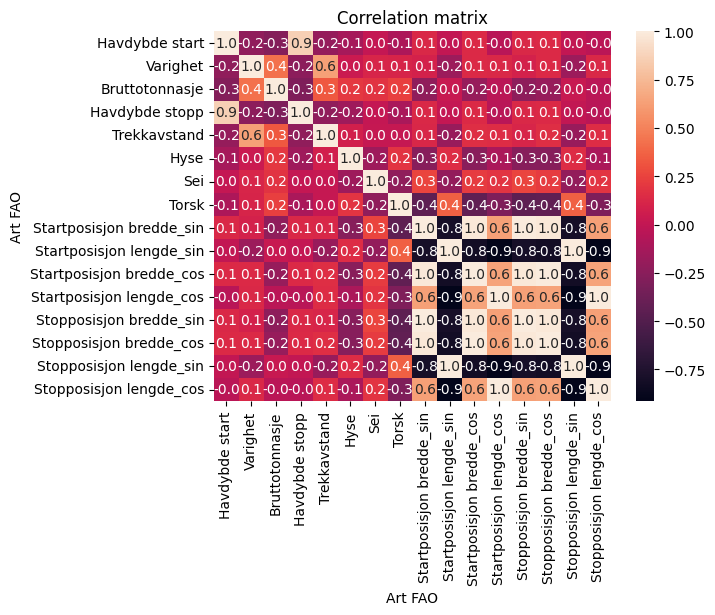

In [251]:
df_corr = df[['Havdybde start','Varighet','Bruttotonnasje', 'Havdybde stopp', 'Trekkavstand', 'Hyse', 'Sei', 'Torsk','Startposisjon bredde_sin','Startposisjon lengde_sin','Startposisjon bredde_cos', 'Startposisjon lengde_cos', 'Stopposisjon bredde_sin', 'Stopposisjon bredde_cos', 'Stopposisjon lengde_sin', 'Stopposisjon lengde_cos' ]]
#plotting the correlation matrix
sns.heatmap(df_corr.corr(), annot=True, fmt=".1f" ) 
plt.title('Correlation matrix')
plt.show() #the correlation matrix does not really tell us any strong relationships between relevant features. The non-linear relationships could still be useful for the model though.

In [252]:
df.shape

(44786, 19)

## <a id='modeling'></a>Modeling (102)
In a machine learning project choosing the right models is of major importance. When having 3 targets you also cancel out a lot of models which cannot handle multiple targets in a good way naturally. Due to the nature of our problem space we have chosen RandomForestRegressor, Gradient Boosting Regressor and MLPRegressor as our 3 supervised models. After having analyzed and explored the data it were indications of non-linearity in the dataframe. The correlation matrix showed no signs of strong relationships between the targets and features. Therefore, the conclusion was made to focus on using models which can handle non-linear relationships, contrary to for example linear regression. 

#### Splitting the data after standard practices (197)

Before diving into the models, it is important to explain the methodology behind splitting the data. The data is split into three parts, training, validation, and test. The training data is used to train the model, the validation data is used to tune the hyperparameters of the model, and the test data is used to evaluate the model. The test data is not used until the final evaluation of the model. Using this practice we will keep test data hidden until final 'exam' evaluation. In our code, we split the data into training and testing sets with an 80/20 split. For clarification, 80% of data is used for training (X_train, y_train) and 20% is used for testing (X_val_test, y_val_test).

###### (Müller & Guido, 2016, p. 262)

<img src="images\ThreefoldSplit.png"
     alt="C:\Users\brohn\MaskinLæring\INFO284\images\ThreefoldSplit.png"
     style="float: left; margin-right: 10px;" />
     

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rfr = RandomForestRegressor(n_jobs=-1, random_state=seed)
standard_scores = cross_val_score(rfr, scaled_df, targets, cv=5, scoring='r2')
print(f"R2 scores: {standard_scores}")
print(f"Mean R2 score: {standard_scores.mean()}")

R2 scores: [0.32272954 0.31390431 0.3029131  0.27905192 0.23658447]
Mean R2 score: 0.2910366657012312


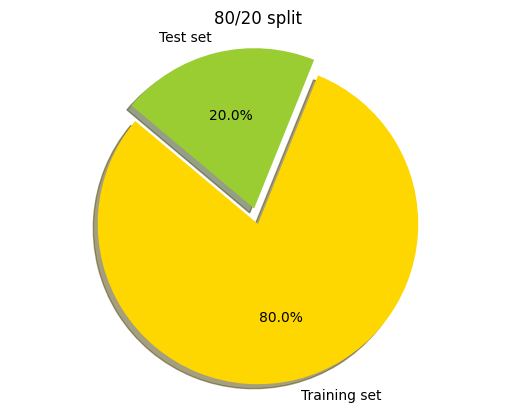

In [256]:
#plotting how we split the data into training validation and testsets

# plotting pie chart

# Data to plot
labels = 'Training set', 'Test set'
sizes = [80,20]
colors = ['gold', 'yellowgreen']
explode = (0.1, 0)  

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('80/20 split')
plt.axis('equal')
plt.show()


The remaining test set is split 75/25 into validation and test sets. This is done to ensure that the model is not overfitted to the validation set. The validation set is used to tune the hyperparameters of the model, while the test set is used to evaluate the model. By following these principles we are able to train, tune and test the models in a competent manner.

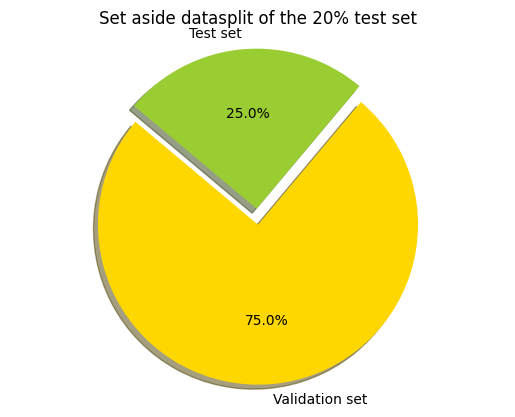

In [260]:
#plotting aside data

# Data to plot
labels = 'Validation set', 'Test set'
sizes = [75,25]
colors = ['gold', 'yellowgreen']
explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Set aside datasplit of the 20% test set')
plt.axis('equal')
plt.show()


The global end split is 80/15/5 for training, validation, and testing.

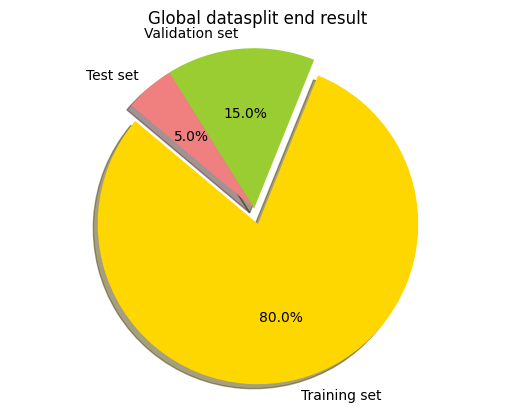

In [261]:
labels = 'Training set', 'Validation set','Test set'
sizes = [80, 15, 5]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Global datasplit end result')
plt.axis('equal')
plt.show()

#### (161)

The first model we implemented was RandomForestRegressor. Random Forests can model non-linear relationships between features and multiple targets. This is very useful regarding the shape of the dataframe. The model offers feature importance which is useful for understanding the features for further engineering and tuning in regards of prediction. Normal decicsion trees tend to overfit the training data compared to random forests(Supervised Machine Learning Algorithms | 83). There is generally no need for scaling the values in RFR, but for simplicities sake we use the same scaled values in everyone. The parameter values used in the first RFR model are all standard. N_jobs=-1 is added for letting our computers run all processors, further improving runtime. The reasoning for this was to keep the runtime low and give a quick impression regarding problem space. It is important to emphasize that using standard parameters does not equal an incompetent model. Parameter values are based on empirical evidence by sklearn themselves.

##### Baseline RandomForestRegressor

In [194]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X_train, X_val_test, y_train, y_val_test = train_test_split(scaled_df, targets, test_size=0.2, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.25, random_state=seed)

rfr_baseline =  RandomForestRegressor(n_jobs=-1, random_state=seed)
rfr_baseline.fit(X_train, y_train)
y_val_pred = rfr_baseline.predict(X_val)
r2_baseline = r2_score(y_val, y_val_pred)
print(f"R2 score: {r2_baseline}")

R2 score: 0.5710982926343485


### KFold Cross Validation  (136)

To ensure that the models do not overfit the data, cross-validation is implemented. Initially, standard cross-validation was used, resulting in a very low R2 score, raising concerns about potential overfitting. To further investigate this, K-Fold cross-validation was implemented. The motivation behind this approach was to gain more insight into the data's sensitivity to variance. There was a suspicion that the data was very sensitive to variance, thus potentially misleading results. Implementing K-Fold was an effort to ensure more robustness against variance.

In [269]:
from sklearn.model_selection import cross_val_score
rfr = RandomForestRegressor(n_jobs=-1, random_state=seed)
standard_scores = cross_val_score(rfr, scaled_df, targets, cv=5, scoring='r2')
print(f"R2 scores: {standard_scores}")
print(f"Mean R2 score: {standard_scores.mean()}")

R2 scores: [0.32272954 0.31390431 0.3029131  0.27905192 0.23658447]
Mean R2 score: 0.2910366657012312


The K-Fold cross-validation showed a considerable improvement, with an average R2 score of 0.57, compared to the 0.29 from the standard cross-validation. This approach is more effective in preventing overfitting by providing a more robust estimate of the model's performance against variance. Continuing in the project, K-Fold cross-validation will be used to evaluate the models.

In [271]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
kf_scores = cross_val_score(rfr_baseline, scaled_df, targets, scoring='r2', cv=kf)

print(f"Cross-validation scores: {kf_scores}")
print(f"Average cross-validation score: {kf_scores.mean()}")

Cross-validation scores: [0.57312212 0.57951324 0.56372437 0.56401229 0.56892198]
Average cross-validation score: 0.5698587999115117


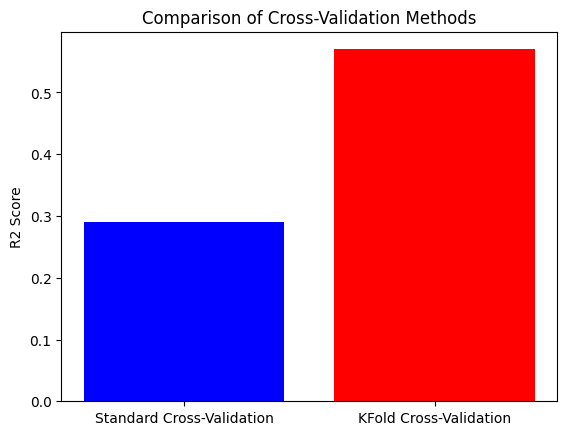

In [272]:
labels = ['Standard Cross-Validation', 'KFold Cross-Validation']
scores = [standard_scores.mean(), kf_scores.mean()]

plt.bar(labels, scores, color=['blue', 'red'])
plt.ylabel('R2 Score')
plt.title('Comparison of Cross-Validation Methods')
plt.show()


### Parameter tuning with grid search (178)
Now that we are evaluating the models properly, we implemented grid search to enhance generalization performance by tuning parameters. Grid search systematically searches for the optimal hyperparameters within a defined grid, trying every combination based on specified interest values. While grid search is computationally expensive, it is necessary for achieving the best results. By fine-tuning the model's hyperparameters, grid search aims to improve performance and robustness, which is critical, particularly in complex models and large datasets. The final test models will use the best parameters from the grid searches, ensuring that the model's performance is optimized.

Random Forest Regressor used the following grid search parameters:
```param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
```
Gradient Boosting Regressor used the following grid search parameters:

```param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
```

The reason why using same parameters is not justified is since the models while similar have different charateristics. Therefore to not loose valuable insight we are maximizing their individual potential. The deep learning model will also be tuned differently due to the nature of the model and is spoken about later in the paper

### RandomForestRegressor with combined features

The second RFR model uses both scaled and onehot-encoded features. One-hot encoding categorical data is a clever way of utilizing more of your data which could be relevant. After best practice we one-hot encoded a relevant categorical column Redskap FAO. So the rfr_combined_features is running the scaled_df features combined with Redskap FAO onehot-encoded values. 

In [182]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

X_train, X_val_test, y_train, y_val_test = train_test_split(features, targets, test_size=0.2, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.25, random_state=seed)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rfr_combined_features = RandomForestRegressor(n_jobs=-1, random_state=seed)
grid_search = GridSearchCV(estimator=rfr_combined_features, param_grid=param_grid, cv=5, scoring='r2', verbose=2)
grid_search.fit(X_train, y_train)

best_rfr = grid_search.best_estimator_
y_val_pred = best_rfr.predict(X_val)
r2_rfr_combined = r2_score(y_val, y_val_pred)
print(f"Validation R2: {r2_rfr_combined}, Best parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  15.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  16.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  15.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  15.9s
[CV] END m

In [183]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
scores = cross_val_score(rfr_combined_features, features, targets, scoring='r2', cv=kf)

print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {scores.mean()}")

Cross-validation scores: [0.58010151 0.58645749 0.57245567 0.57342161 0.57418899]
Average cross-validation score: 0.5773250567149447


### Implementing Feature Importance

In [277]:

def plot_feature_importances(model, feature_columns):
    n_features = len(feature_columns.columns)
    feature_indices = feature_columns.columns.tolist()
    feature_importances = model.feature_importances_
    #adding if statement to remove the one-hot encoded columns that have no importance


    fig = plt.figure(figsize=(12,14))
    plt.subplot(111)
    plt.barh(range(n_features), feature_importances, height=1, color='b', align='center')
    plt.yticks(np.arange(n_features), feature_indices[:n_features])
    plt.xlabel("Feature importances")
    plt.ylabel("Feature")
    plt.title("Feature importances of the model {}".format(model.__class__.__name__))
    plt.tight_layout(pad=0.5)
plot_feature_importances(rfr_combined_features, features)


features.shape
# This graph shows the feature importance of the randomforest model.
# A lot of the one-hot encoded features seem to have no importance. We tried collapsing all the seemingly irrelevant ones into a single column.
# That seemed to worsen the R2 score from 0.637-642 to around 0.44 so we've decided to keep them for now even though this graph seems to indicate their lack of importance.

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Gradient Boosting

In [ ]:
X_train, X_val_test, y_train, y_val_test = train_test_split(features, targets, test_size=0.2, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.25, random_state=seed)

from sklearn.ensemble import GradientBoostingRegressor
param_grid = {
    'n_estimators': [None,100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gbr_combined_features = GradientBoostingRegressor(random_state=seed)
grid_search = GridSearchCV(estimator=gbr_combined_features, param_grid=param_grid, cv=5, scoring='r2', verbose=2)
grid_search.fit(X_train, y_train)

best_gbr = grid_search.best_estimator_
y_val_pred = best_gbr.predict(X_val)
r2_gbr = r2_score(y_val, y_val_pred)
print(f"Validation R2: {r2_gbr} Best parameters: {grid_search.best_params_}")

In [ ]:
# #crossvalidating xgb
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
scores = cross_val_score(gbr_combined_features, features, targets, scoring='r2', cv=kf)

print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {scores.mean()}")

KeyboardInterrupt: 

### MLPRegressor

#### Parameters for MLPRegressor

In [ ]:
from sklearn.neural_network import MLPRegressor

X_train, X_val_test, y_train, y_val_test = train_test_split(features, targets, test_size=0.2, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.25, random_state=seed)

param_grid = {
    'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01]
}

mlp_combined_features = MLPRegressor(random_state=seed)
grid_search = GridSearchCV(estimator=mlp_combined_features, param_grid=param_grid, cv=5, scoring='r2', verbose=2)
grid_search.fit(X_train, y_train)

best_mlp = grid_search.best_estimator_
y_val_pred = best_mlp.predict(X_val)
print(best_mlp)
r2_mlp = r2_score(y_val, y_val_pred)
print(f"Validation R2: {r2_mlp} Best parameters: {grid_search.best_params_}")


NameError: name 'features' is not defined

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=seed)
scores = cross_val_score(mlp_combined_features, features, targets, scoring='r2', cv=kf)

print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {scores.mean()}")

### Analyzing Results on non-test data

Text(0.5, 1.0, 'R2 scores of the models')

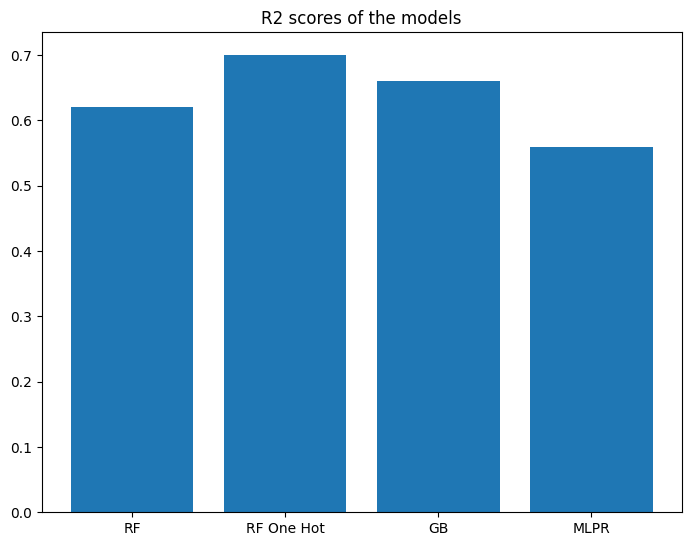

In [ ]:
#plotting all the r2 scores from each model
models = ['Random Forest','Random Forest OneHot', 'XGBoost', 'MLP']
r2_scores = [r2_baseline,r2_rfr_combined, r2_gbr, r2_mlp]
plt.bar(models, r2_scores)
plt.xlabel('Models')
plt.ylabel('R2 Scores')
plt.title('R2 Scores of the models')
plt.show()

### Testing the models on the test set

In [ ]:
# y_test_pred = best_rfr.predict(X_test)
# r2_rfr = r2_score(y_test, y_test_pred)
# print(f"Random Forest R2: {r2_rfr}")

# y_test_pred = best_gbr.predict(X_test)
# r2_gbr = r2_score(y_test, y_test_pred)
# print(f"GradientBoost R2: {r2_gbr}")

# y_test_pred = best_mlp.predict(X_test)
# r2_mlp = r2_score(y_test, y_test_pred)
# print(f"MLP R2: {r2_mlp}")

### Discussing test model results

dropp kommentarer. except for tekniske ting
vise dataen underveis
dropna, påstander om hvorfor vi dropper de, bevis 
vise distribusjon av outliers
fillNA, groupBy, meldingsid, startstidspunkt
robustScaler, hvorfor vi bruker det, outliers
scalingData for modellene, forklar
gradientBoosting, scaling data hvorfor? Bedre optimum, forklare MultioutputRegressor









### Citations